In [1]:
import numpy
import jax
from matplotlib import pyplot as plt
from jax import numpy as jnp
from jax import jit as jjit
from jax import vmap

mred = u'#d62728' 
mgreen = u'#2ca02c'
mblue = u'#1f77b4' 

In [2]:
from sn_diffstar.load_bpl import *
from sn_diffstar.mspop import *
from sn_diffstar.utils import *

In [3]:
from jax import random as jran
ran_key = jran.PRNGKey(0)

## Read in data

In [4]:
data = load_bpl_diffstar_data(MY_MPL_DRN)

## Pick an arbitray slice and associated cosmic time to consider

In [5]:
sslice = 110
t0s=data[1][sslice]
print(t0s)

6.7919099935881455


## Confirm ordering of fit parameters

In [6]:
print(data[2][0])

['mah_fit_logmp', 'mah_fit_logtc', 'mah_fit_early_index', 'mah_fit_late_index']


## Get stellar mass for sim and fit for a subset of galaxies

In [7]:
logSM_sim=[]
logSM_fit=[]
tarr = jnp.linspace(0.1, t0s, 200)
count=0
for row in data[0]:
    if (count % 1000) == 0:
        mah_params_one= numpy.array(list(row[data[2][0]]))
        ms_u_params_pop, ms_sfh_pop, ms_logsmh_pop = mc_galhalo_ms_lgmpop(ran_key, mah_params_one[None,:], tarr)
        logSM_fit.append(ms_logsmh_pop[0,-1])
        logSM_sim.append(row['logsmh_sim'][sslice])
    count = count+1

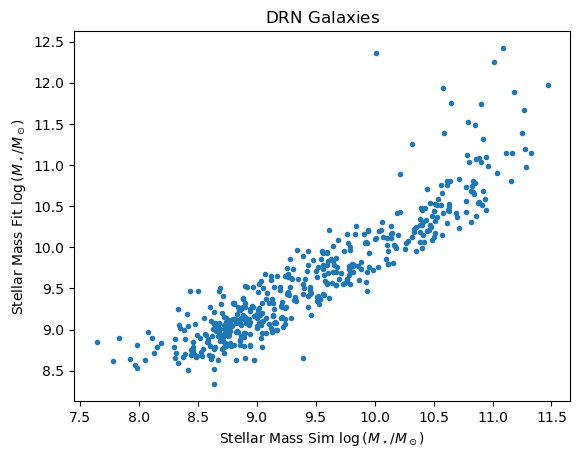

In [8]:
fig, ax = plt.subplots(1, 1)
__=ax.plot(logSM_sim, logSM_fit, '.')

tlabel = ax.set_title(r'${\rm DRN\ Galaxies}$')
xlabel = ax.set_xlabel(r'${\rm Stellar\ Mass\ Sim\ } \log{(M_\star/M_\odot)}$')
xlabel = ax.set_ylabel(r'${\rm Stellar\ Mass\ Fit\ } \log{(M_\star/M_\odot)}$')

In [ ]:
logSM_fit=data[0]['logsmh_sim'].value[:,sslice].shape

In [ ]:
fig, ax = plt.subplots(1, 1)
__=ax.plot(logSM_fit, ms_logsmh_pop[:,-1],'.',label='fit',alpha=0.2)

xlabel = ax.set_title(r'${\rm DRN\ Galaxies}$')
xlabel = ax.set_xlabel(r'${\rm Stellar\ Mass\ } \log{(M_\star/M_\odot)}$')
ylabel = ax.set_ylabel(r'$ \log{\rm SN\ Rate\ }[{\rm galaxy}^{-1}{\rm yr}^{-1}]$')


In [ ]:
logSM_fit=[]
SNR_fit=[]
ind=0
for row in data[0]:
#     t0s=numpy.random.uniform(5,13)
    if (ind % 100) == 0:
        mah_params=numpy.fromiter(row[data[2][0]].values(),float,-1)
        logSM_fit.append(logSM(t0s,mah_params))
        SNR_fit.append(SNR(t0s, A, beta, tp, mah_params))
    ind = ind+1

In [ ]:
logSM_sim=[]
SNR_sim=[]
ind=0
ilim= t0s - tp
# this is buggy if tp is larger than a slice...
x = data[1][:sslice]
x = numpy.append(x,ilim)

if not numpy.all(numpy.diff(x) > 0):
    print('Bad things happening')
    exit()

for row in data[0]:
#     t0s=numpy.random.uniform(5,13)
    if (ind % 100) == 0:      
        logSM_sim.append(row['logsmh_sim'][sslice])
        
        flim= numpy.interp(ilim,data[1],row['sfrh_sim'])
        y = row['sfrh_sim'][:sslice]
        y = numpy.append(y,flim)
        integral = 1e9 * A * numpy.trapz(y*numpy.power(t0s-x,beta),x)
                       
        SNR_sim.append(integral)
    ind = ind+1

In [ ]:
fig, ax = plt.subplots(1, 1)
__=ax.plot(logSM_fit, numpy.log10(SNR_fit),'.',label='fit',alpha=0.2)

__=ax.plot(logSM_sim, numpy.log10(SNR_sim),'.',label='sim',alpha=0.2)

xlabel = ax.set_title(r'${\rm DRN\ Galaxies}$')
xlabel = ax.set_xlabel(r'${\rm Stellar\ Mass\ } \log{(M_\star/M_\odot)}$')
ylabel = ax.set_ylabel(r'$ \log{\rm SN\ Rate\ }[{\rm galaxy}^{-1}{\rm yr}^{-1}]$')


# t0s=numpy.random.uniform(5, 13., Ngal)
# __=ax.plot(logSM_mah(t0s, mah_params_pop), jnp.log10(SNR_mah(t0s, A, beta, tp, mah_params_pop)),'.',label='MS')
ax.legend()


In [ ]:
data[0]

In [ ]:
data[1][sslice]

In [ ]:
dum=(data[1][:sslice])

In [ ]:
print(numpy.all(numpy.diff(x) > 0))

## DIFFSTAR SFH
Use an example galaxy that has been parameterized by DIFFSTAR

In [ ]:
from diffmah.monte_carlo_halo_population import mc_halo_population

Ngal=500
T0 = 13.8
tarr = numpy.linspace(0.1, T0, 200)

logmhpop = numpy.zeros(Ngal) + 12.0
halopop = mc_halo_population(tarr, T0, logmhpop)

# Collect mah_params into array of shape (n_halos, 4)
mah_params_pop = numpy.array((halopop.log_mah[:, -1], halopop.lgtc, halopop.early_index, halopop.late_index)).T

In [ ]:
halopop.log_mah.shape

## Supernova Rate

In [ ]:
from sn_diffstar.utils import *

In [ ]:
t0=5
betas = numpy.linspace(-1.25,-1,20)
tps= numpy.linspace(0.02,0.06,20)

In [ ]:
t0s=numpy.random.uniform(5, 13., Ngal)
fig, ax = plt.subplots(1, 1)
__=ax.plot(logSM_gal(t0s, mah_params_pop), jnp.log10(SNR_gal(t0s, A, beta, tp, mah_params_pop)),'.')
xlabel = ax.set_title(r'${\rm Diffstar\ Main\ Sequence\ Galaxies}$')
xlabel = ax.set_xlabel(r'${\rm Stellar\ Mass\ } \log{(M_\star/M_\odot)}$')
ylabel = ax.set_ylabel(r'$ \log{\rm SN\ Rate\ }[{\rm galaxy}^{-1}{\rm yr}^{-1}]$')

In [ ]:
t0s=numpy.random.uniform(5, 13., Ngal)
fig, ax = plt.subplots(1, 1)
__=ax.plot(t0s, SNR_gal(t0s, A, beta, tp, mah_params_pop),'.')
xlabel = ax.set_title(r'${\rm Diffstar\ Main\ Sequence\ Galaxies}$')
ylabel = ax.set_ylabel(r'${\rm SN\ Rate}$')

In [ ]:
fig, ax = plt.subplots(1, 1)
__=ax.plot(betas, SNR_beta(t0, A, betas, tp, mah_params_pop[0,:]))
xlabel = ax.set_xlabel(r'$\beta$')
xlabel = ax.set_title(r'${{\rm One\ Diffstar\ Main\ Sequence\ Galaxy}}$ at Lookback {} Gyr'.format(t0))
ylabel = ax.set_ylabel(r'${\rm SN\ Rate}$')

In [ ]:
fig, ax = plt.subplots(1, 1)
__=ax.plot(tps, SNR_tp(t0, A, beta, tps, mah_params_pop[0,:]))
xlabel = ax.set_xlabel(r'$t_p (Gyr)$')
xlabel = ax.set_title(r'${{\rm One\ Diffstar\ Main\ Sequence\ Galaxy}}$ at Lookback {} Gyr'.format(t0))
ylabel = ax.set_ylabel(r'${\rm SN\ Rate}$')

In [ ]:
fig, ax = plt.subplots(1, 1)
im=ax.imshow(SNR_beta_tp(t0, A, betas, tps, mah_params_pop[0,:]),extent=[betas[0], betas[-1], tps[0], tps[-1]])
ax.set_aspect(7)
fig.colorbar(im, ax=ax,label='SN Rate')
xlabel = ax.set_xlabel(r'$\beta$')
xlabel = ax.set_ylabel(r'$t_p (Gyr)$')
xlabel = ax.set_title(r'${{\rm One\ Diffstar\ Main\ Sequence\ Galaxy}}$ at Lookback {} Gyr'.format(t0))

### As a function of DDT parameters

In [ ]:
t0s=jnp.linspace(0.1, 13.8, 10)
fig, ax = plt.subplots(1, 1)
__=ax.plot(t0s, SNR_t0(t0s, A, beta, tp, mah_params_pop[0,:]))
xlabel = ax.set_xlabel(r'${\rm cosmic\ time\ [Gyr]}$')
xlabel = ax.set_title(r'${\rm Diffstar\ Main\ Sequence\ Galaxies}$')
ylabel = ax.set_ylabel(r'${\rm SN\ Rate}$')

In [ ]:
fig, ax = plt.subplots(1, 1)
__=ax.plot(SNR_mah(5, A, beta, tp, mah_params_pop))
xlabel = ax.set_title(r'${\rm Diffstar\ Main\ Sequence\ Galaxies}$')
ylabel = ax.set_ylabel(r'${\rm SN\ Rate}$')

In [ ]:
t0s=jnp.linspace(0.1, 13.5, 20)
fig, ax = plt.subplots(1, 1)
__=ax.plot(t0s, SNR_t0_mah(t0s, A, beta, tp, mah_params_pop))
xlabel = ax.set_xlabel(r'${\rm cosmic\ time\ [Gyr]}$')
xlabel = ax.set_title(r'${\rm Diffstar\ Main\ Sequence\ Galaxies}$')
ylabel = ax.set_ylabel(r'${\rm SN\ Rate}$')

## Delay time distribution (DTD) Eq. 6 of https://academic.oup.com/mnras/article/506/3/3330/6318383?login=false

In [ ]:
@jjit
## tau    (Gyr)
## tp      (Gyr)
## A   (1e-13 M^{-1}_{sun} yr^{-1}
##
##  Nominal values A=2.11; beta=-1.13; tp=0.04

def DTD(tau, A, beta, tp):
    return jax.lax.cond(tau < tp, lambda a: 0., lambda a : a[0]*jnp.power(a[1],a[2]), [A, tau, beta])

In [ ]:
DTD_vmap = jjit(vmap(DTD, in_axes=(0, None, None, None)))

In [ ]:
tau = jnp.linspace(0, 1, 100)
fig, ax = plt.subplots(1, 1)
__=ax.plot(tau, DTD_vmap(tau, A, beta, tp))